In [1]:
import tweepy
import time
import requests
import json
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import json
import pandas as pd
from config_Sara import consumer_key,consumer_secret,access_token,access_token_secret,maps_key,place_key

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [118]:
citiescsv = "cities1.csv"
cities_df = pd.read_csv(citiescsv)
cities_df=cities_df.rename(columns={"City/Region": "City"})
cities_df["City"]=cities_df["City"].str.lower()
previousrank1 = pd.read_csv("twitter_ranksmarch23.csv")
previousrank2 = pd.read_csv("twitter_ranksmarch24.csv")

In [5]:
##Determines the latitude and longitude for each city
##We only wants tweets that are coming from these areas
cities_lat_long = {}
for index,row in cities_df.iterrows():
    target_city = cities_df["City"][index]+ ", "+cities_df["State"][index]
    target_url = "https://maps.googleapis.com/maps/api/geocode/json?" \
    "address=%s&key=%s" % (target_city, maps_key)
    geo_data = requests.get(target_url).json()
    lat = geo_data["results"][0]["geometry"]["location"]["lat"]
    lng = geo_data["results"][0]["geometry"]["location"]["lng"]
    cities_lat_long[cities_df["City"][index]] = [lat,lng]
    
    
  

In [10]:
dict_of_tweets_cities = {}
dict_of_tweet_text = {}
for index,row in cities_df.iterrows():
    search_term = row["City"]
    lat1 =  cities_lat_long[row["City"]][0]
    lng1 =  cities_lat_long[row["City"]][1]
    ##for 500 tweets per city
    oldest_tweet = None
# Save the list of tweets
    tweet_array = []
    tweet_text_array = []
    for x in range(5):
        public_tweets = api.search(search_term, geocode =str(lat1)+","+str(lng1)+","+"30mi",count = 100,result_type="recent",max_id=oldest_tweet)
        for tweet in public_tweets["statuses"]:
            tweet_array.append(tweet)
            tweet_text_array.append(tweet["text"])
            oldest_tweet = int(tweet["id_str"])
            oldest_tweet = oldest_tweet-1
    dict_of_tweets_cities[row["City"]] = tweet_array
    dict_of_tweet_text[row["City"]] = tweet_text_array
    
 

In [16]:
sentiments = []
for key in dict_of_tweet_text:
    
    tweets = dict_of_tweet_text[key] 
    count1 = 0
    
    for tweet in tweets:
        
        compound = analyzer.polarity_scores(tweet)["compound"]
        pos = analyzer.polarity_scores(tweet)["pos"]
        neu = analyzer.polarity_scores(tweet)["neu"]
        neg = analyzer.polarity_scores(tweet)["neg"]
        tweets_ago = count1
        #tweet_text = tweet["text"] 
        sentiments.append({"City": key,
                      #   "Date": tweet["created_at"],
                         "Compound": compound,
                         "Positive": pos,
                         "Negative": neg,
                         "Neutral": neu,
                         "Tweets Ago": count1,
                         "Text": tweet})
        count1+=1
        
        

In [94]:
sentiments_cities = pd.DataFrame.from_dict(sentiments)
sentiments_cities.head()

,City,Compound,Negative,Neutral,Positive,Text,Tweets Ago
0,atlanta,0.4215,0.0,0.851,0.149,"""Adaptability is about the powerful difference...",0
1,atlanta,0.0000,0.0,1.000,0.000,RT @ryangravel: #MarchForOurLives #Atlanta htt...,1
2,atlanta,0.4019,0.0,0.764,0.236,Just played: SCAD ATLANTA RADIO - Do You Want ...,2
3,atlanta,0.5267,0.0,0.746,0.254,RT @peach_usb: Vibrant Thing 🙏🏽\n\n#UsbDripCha...,3
4,atlanta,0.0000,0.0,1.000,0.000,Client Spotlight: -&gt; @MBStadium Preview Cen...,4


In [21]:
avg_sent = sentiments_cities.groupby("City")
means_sentiments = pd.DataFrame(avg_sent["Compound"].mean())
means_sentiments

,Compound
City,
alexandria,0.043773
atlanta,0.150022
austin,0.165425
boston,0.058769
chicago,0.124053
columbus,0.075362
dallas,0.173084
denver,0.183526
indianapolis,0.061197


In [22]:
means_sentiments.reset_index(level=0,inplace = True)

In [23]:
means_sentiments
means_sentiments_max = max(means_sentiments["Compound"])
means_sentiments_min = min(means_sentiments["Compound"])
means_sentiments_range = means_sentiments_max-means_sentiments_min
means_sentiments["Degree_score"]=1.0

In [24]:
for index,row in means_sentiments.iterrows():
    score = (row["Compound"]-means_sentiments_min)/means_sentiments_range*10
    score = round(score,1)
    means_sentiments.set_value(index,"Degree_score",score)

In [25]:
means_sentiments.sort_values("Degree_score",ascending=False)

In [96]:
means_sentiments.to_csv("twitter_ranksmarch25.csv")

In [96]:
previousrank1
previousrank2
final_df = pd.merge(previousrank1,previousrank2,on="City",how="outer")
final_df = pd.merge(final_df,means_sentiments,on="City",how="outer")

In [103]:
final_df_max = max(final_df["Total Degree Score"])
final_df_min = min(final_df["Total Degree Score"])
final_df_range = final_df_max-final_df_min
final_df["Final Degree Score"]=1.0

In [107]:
for index,row in final_df.iterrows():
    score = (row["Total Degree Score"]-final_df_min)/final_df_range*10
    score = round(score,1)
    final_df.set_value(index,"Final Degree Score",score)
    
    

In [110]:
final_df.to_csv("Finalrank.csv")

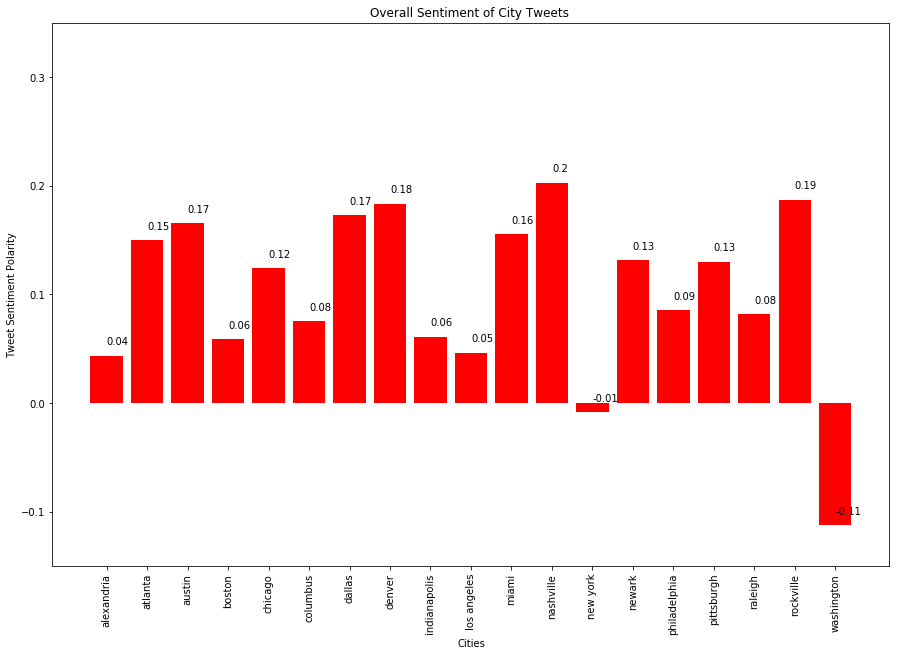

In [121]:
fig, ax = plt.subplots(figsize = (15,10))

mean_sentiments =avg_sent["Compound"].mean()

x_axis = np.arange(len(mean_sentiments))
count2 = 0
count = 0
for sent in mean_sentiments:
    ax.text(count2, sent+.01, str(round(sent,2)))
    count2+=1
plt.ylim(-.15,.35)
plt.bar(x_axis, mean_sentiments, tick_label = list(mean_sentiments.index), color = 'r')
plt.title("Overall Sentiment of City Tweets ")
plt.xlabel("Cities")
plt.ylabel("Tweet Sentiment Polarity")
plt.xticks(rotation=90)
plt.savefig("Overall Sentiment of City Tweets 1")
plt.show()

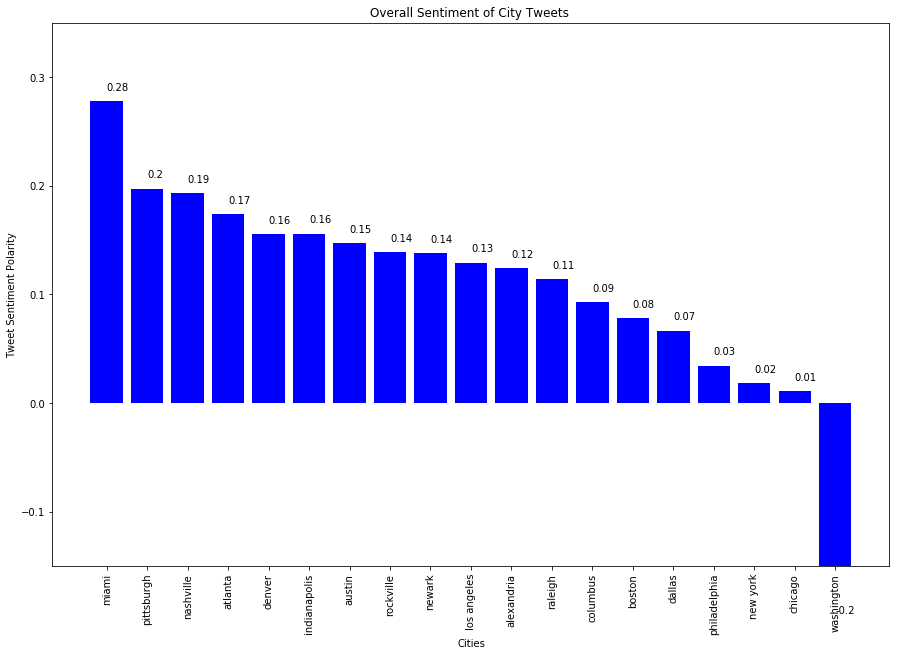

In [120]:
fig, ax = plt.subplots(figsize = (15,10))

#mean_sentiments =avg_sent["Compound"].mean()

x_axis = np.arange(len(previousrank1["Compound"]))
count2 = 0
count = 0
for sent in previousrank1["Compound"]:
    ax.text(count2, sent+.01, str(round(sent,2)))
    count2+=1
plt.ylim(-.15,.35)
plt.bar(x_axis, previousrank1["Compound"], tick_label = list(previousrank1["City"]), color = 'b')
plt.title("Overall Sentiment of City Tweets ")
plt.xlabel("Cities")
plt.ylabel("Tweet Sentiment Polarity")
plt.xticks(rotation=90)
plt.savefig("Overall Sentiment of City Tweets 2")
plt.show()

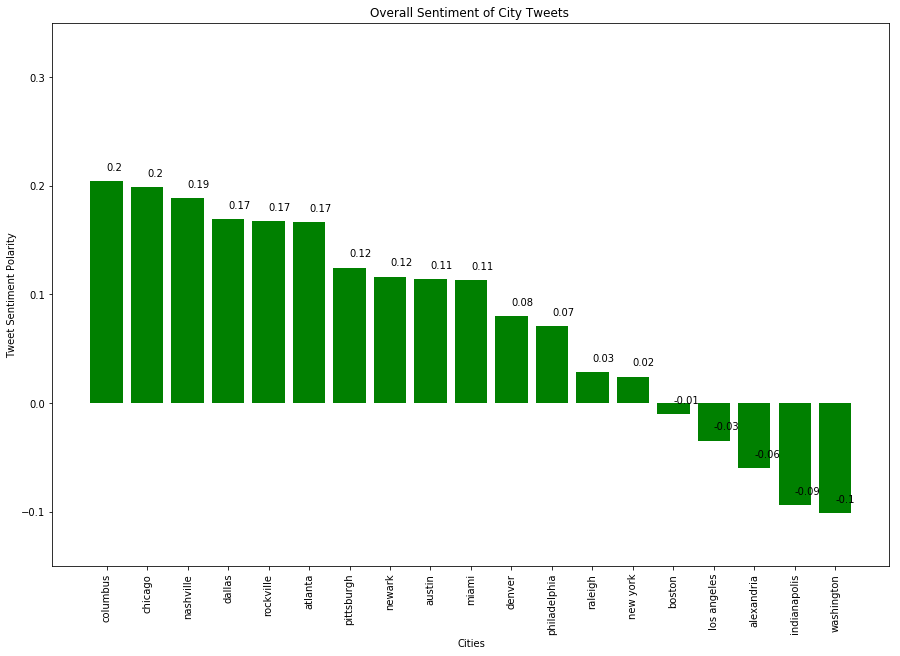

In [122]:
fig, ax = plt.subplots(figsize = (15,10))

#mean_sentiments =avg_sent["Compound"].mean()

x_axis = np.arange(len(previousrank2["Compound"]))
count2 = 0
count = 0
for sent in previousrank2["Compound"]:
    ax.text(count2, sent+.01, str(round(sent,2)))
    count2+=1
plt.ylim(-.15,.35)
plt.bar(x_axis, previousrank2["Compound"], tick_label = list(previousrank2["City"]), color = 'g')
plt.title("Overall Sentiment of City Tweets ")
plt.xlabel("Cities")
plt.ylabel("Tweet Sentiment Polarity")
plt.xticks(rotation=90)
plt.savefig("Overall Sentiment of City Tweets 3")
plt.show()